<a href="https://www.kaggle.com/code/sagorkumarmitra/pima-indians-diabetes-database?scriptVersionId=141664550" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import parallel_coordinates,andrews_curves,radviz
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [4]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.inspection import permutation_importance
import shap
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

In [5]:
data=pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')

In [6]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
duplicate_rows_data=data[data.duplicated()]

In [8]:
print("Number of Duplicated rows:",duplicate_rows_data.shape)

Number of Duplicated rows: (0, 9)


In [9]:
print(data.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [10]:
for column in data.columns:
    num_distinct_values=len(data[column].unique())
    print(f"{column}:{num_distinct_values} distinct values")

Pregnancies:17 distinct values
Glucose:136 distinct values
BloodPressure:47 distinct values
SkinThickness:51 distinct values
Insulin:186 distinct values
BMI:248 distinct values
DiabetesPedigreeFunction:517 distinct values
Age:52 distinct values
Outcome:2 distinct values


In [11]:
data.describe().style.format("{:.2f}")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [13]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


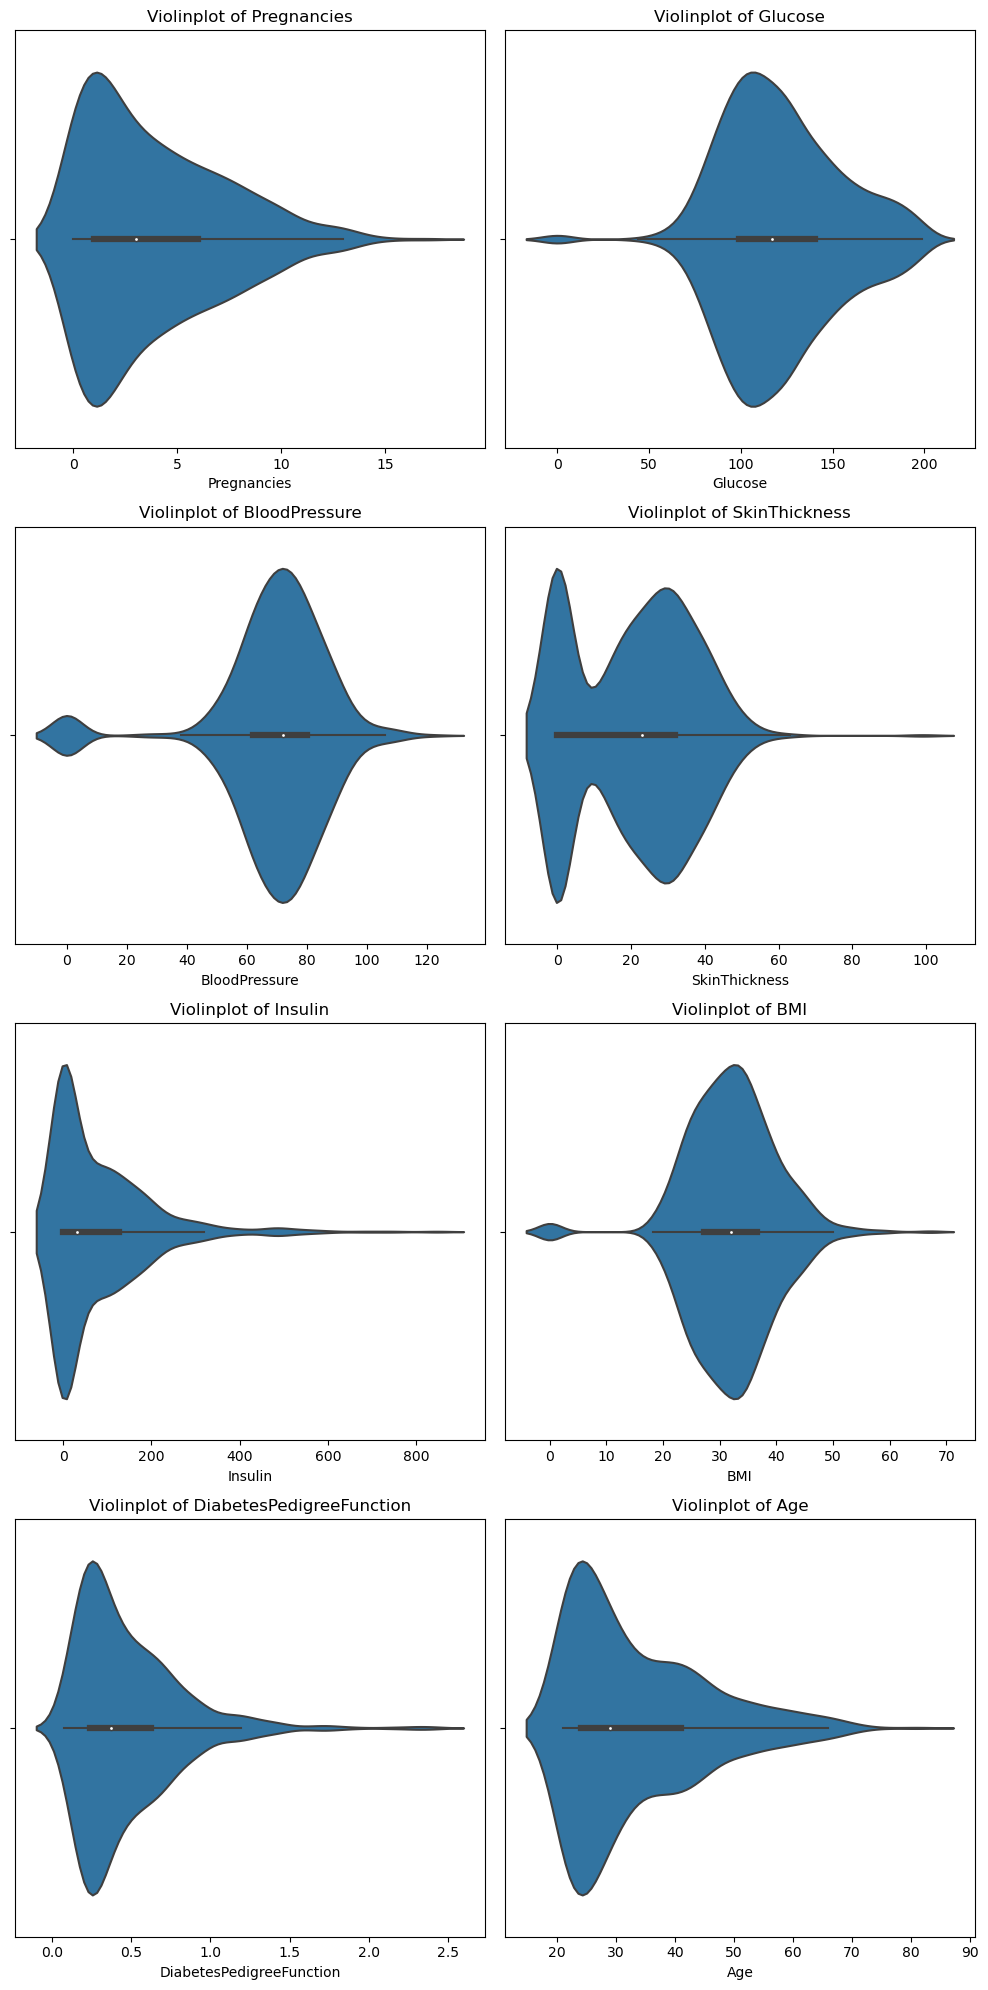

In [14]:
num_columns=len(data.columns.drop('Outcome'))
num_rows=(num_columns + 1) // 2

plt.figure(figsize=(10,5*num_rows))
for i, column in enumerate(data.columns.drop('Outcome')):
    plt.subplot(num_rows,2,i+1)
    sns.violinplot(x=data[column])
    plt.title(f'Violinplot of {column}')
    
plt.tight_layout()
plt.show()

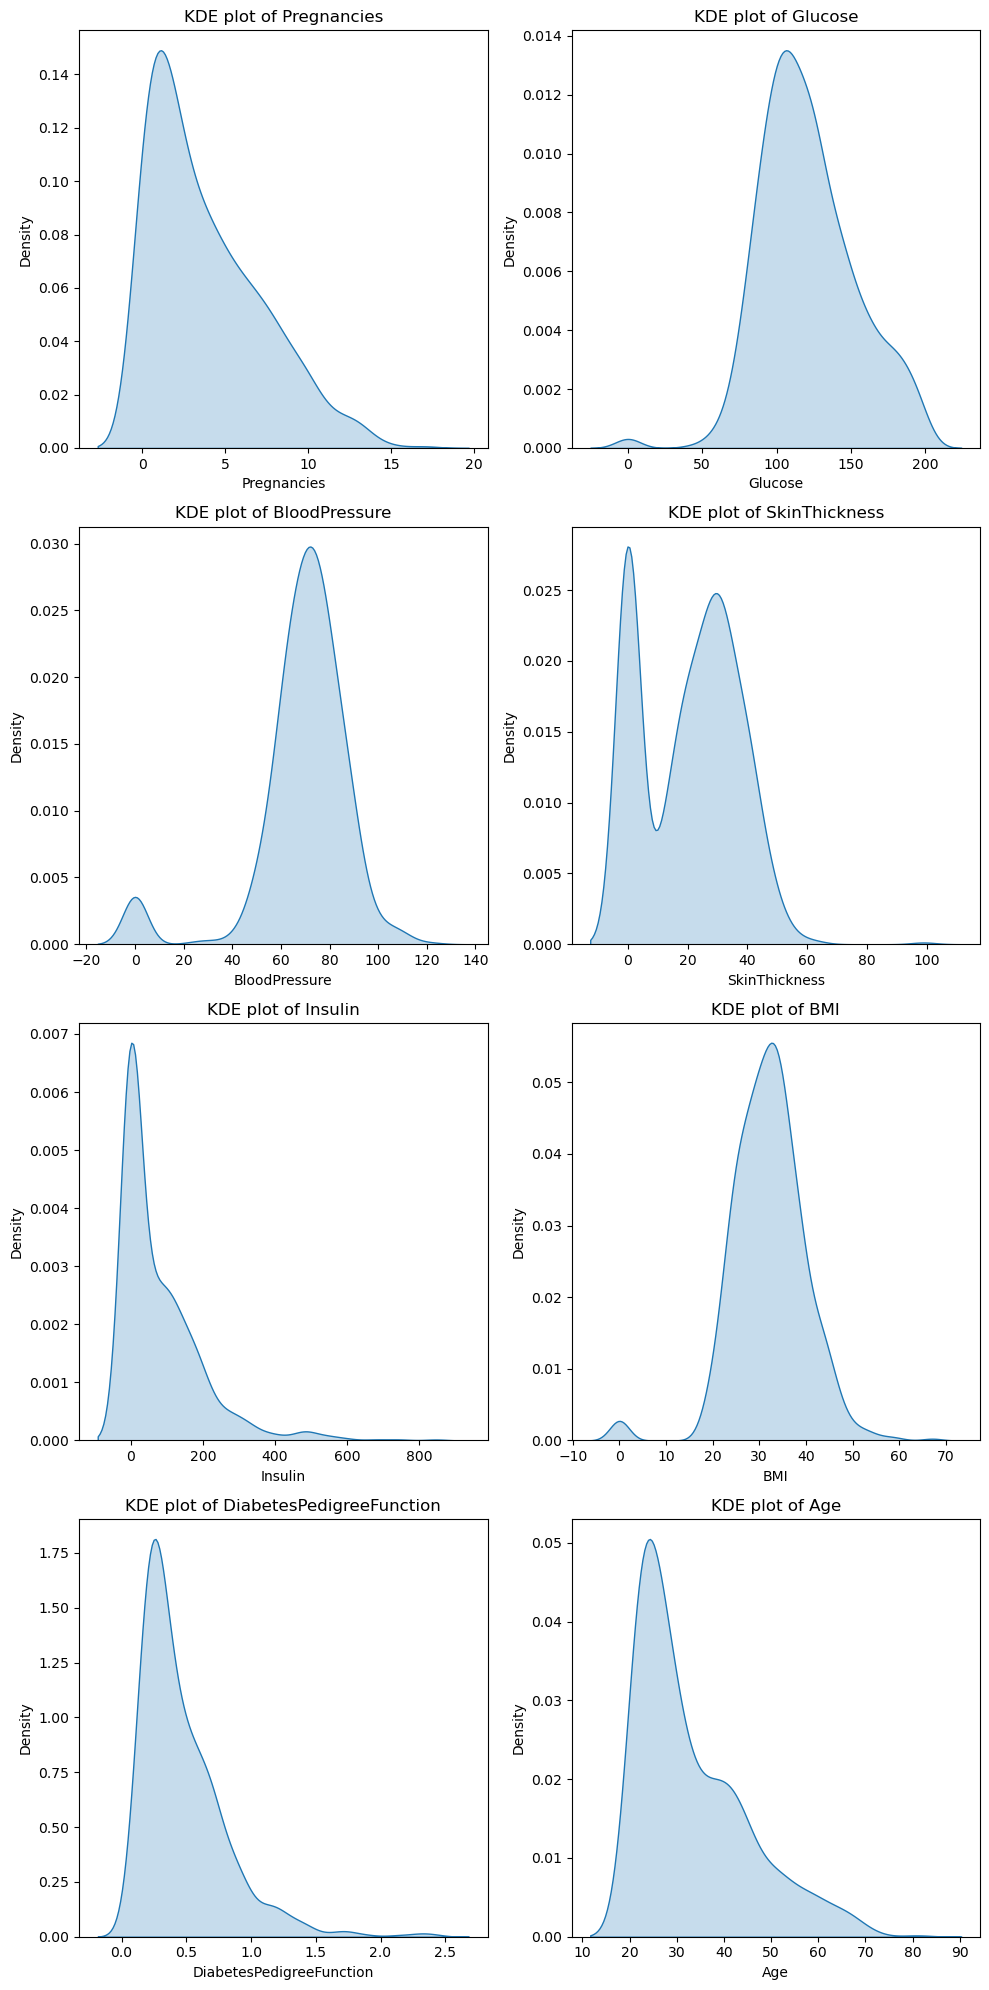

In [15]:
num_columns=len(data.columns.drop('Outcome'))
num_rows=(num_columns + 1) // 2
plt.figure(figsize=(10,5*num_rows))
for i, column in enumerate(data.columns.drop('Outcome')):
    plt.subplot(num_rows,2,i+1)
    sns.kdeplot(data=data[column],fill=True)
    plt.title(f'KDE plot of {column}')
    
plt.tight_layout()
plt.show()

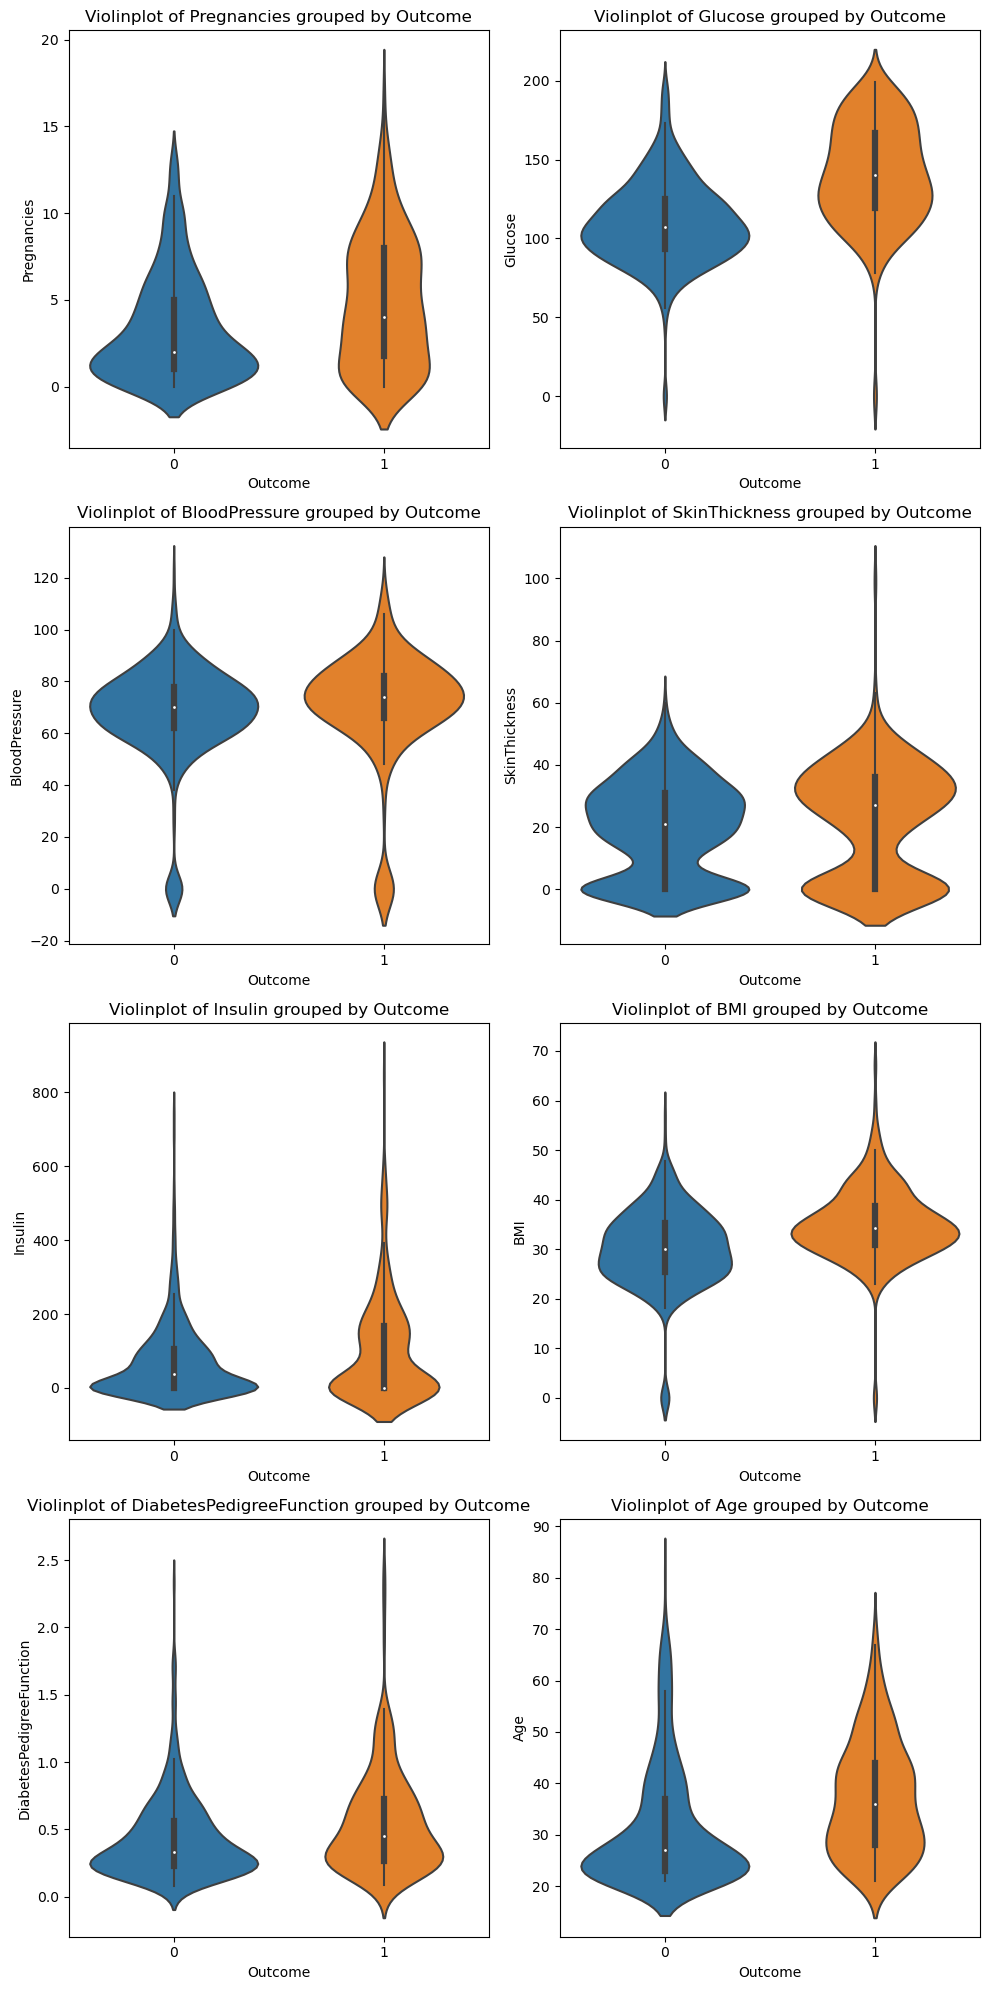

In [16]:
num_columns=len(data.columns.drop('Outcome'))
num_rows=(num_columns + 1) // 2

plt.figure(figsize=(10,5*num_rows))
for i, column in enumerate(data.columns.drop('Outcome')):
    plt.subplot(num_rows,2,i+1)
    sns.violinplot(data=data,x='Outcome',y=column)
    plt.title(f'Violinplot of {column} grouped by Outcome')
    
plt.tight_layout()
plt.show()

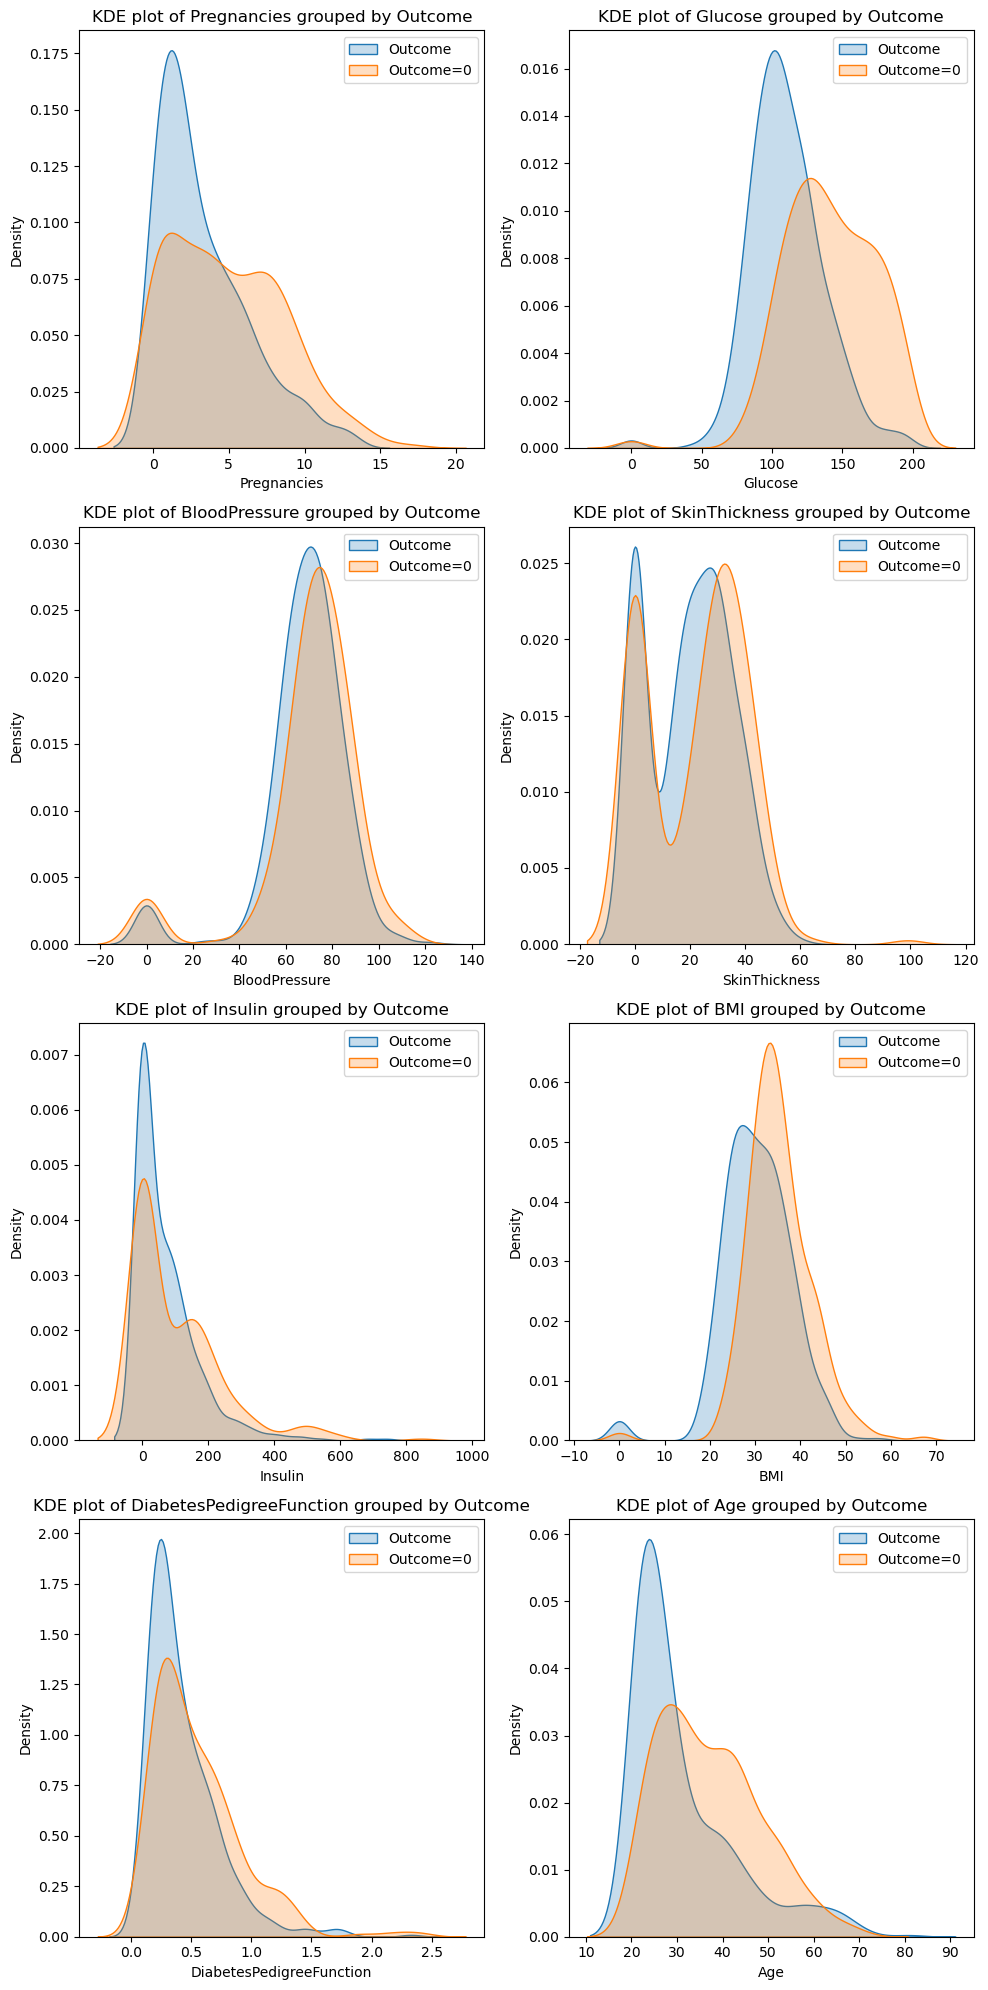

In [17]:
num_columns=len(data.columns.drop('Outcome'))
num_rows=(num_columns + 1)//2

plt.figure(figsize=(10,5*num_rows))
for i,column in enumerate(data.columns.drop('Outcome')):
    plt.subplot(num_rows,2,i+1)
    sns.kdeplot(data=data[data['Outcome']==0][column],label='Outcome',fill=True)
    sns.kdeplot(data=data[data['Outcome']==1][column],label='Outcome=0',fill=True)
    plt.title(f'KDE plot of {column} grouped by Outcome')
    plt.legend()
    
plt.tight_layout()
plt.show()

In [18]:
data[data['Outcome']==1].head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
2,8,183,64,0,0,23.3,0.672,32,1
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1
8,2,197,70,45,543,30.5,0.158,53,1


In [19]:
data[data['Outcome']==1][column]

0      50
2      32
4      33
6      26
8      53
       ..
755    37
757    52
759    66
761    43
766    47
Name: Age, Length: 268, dtype: int64

In [20]:
data.columns.drop('Outcome')

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

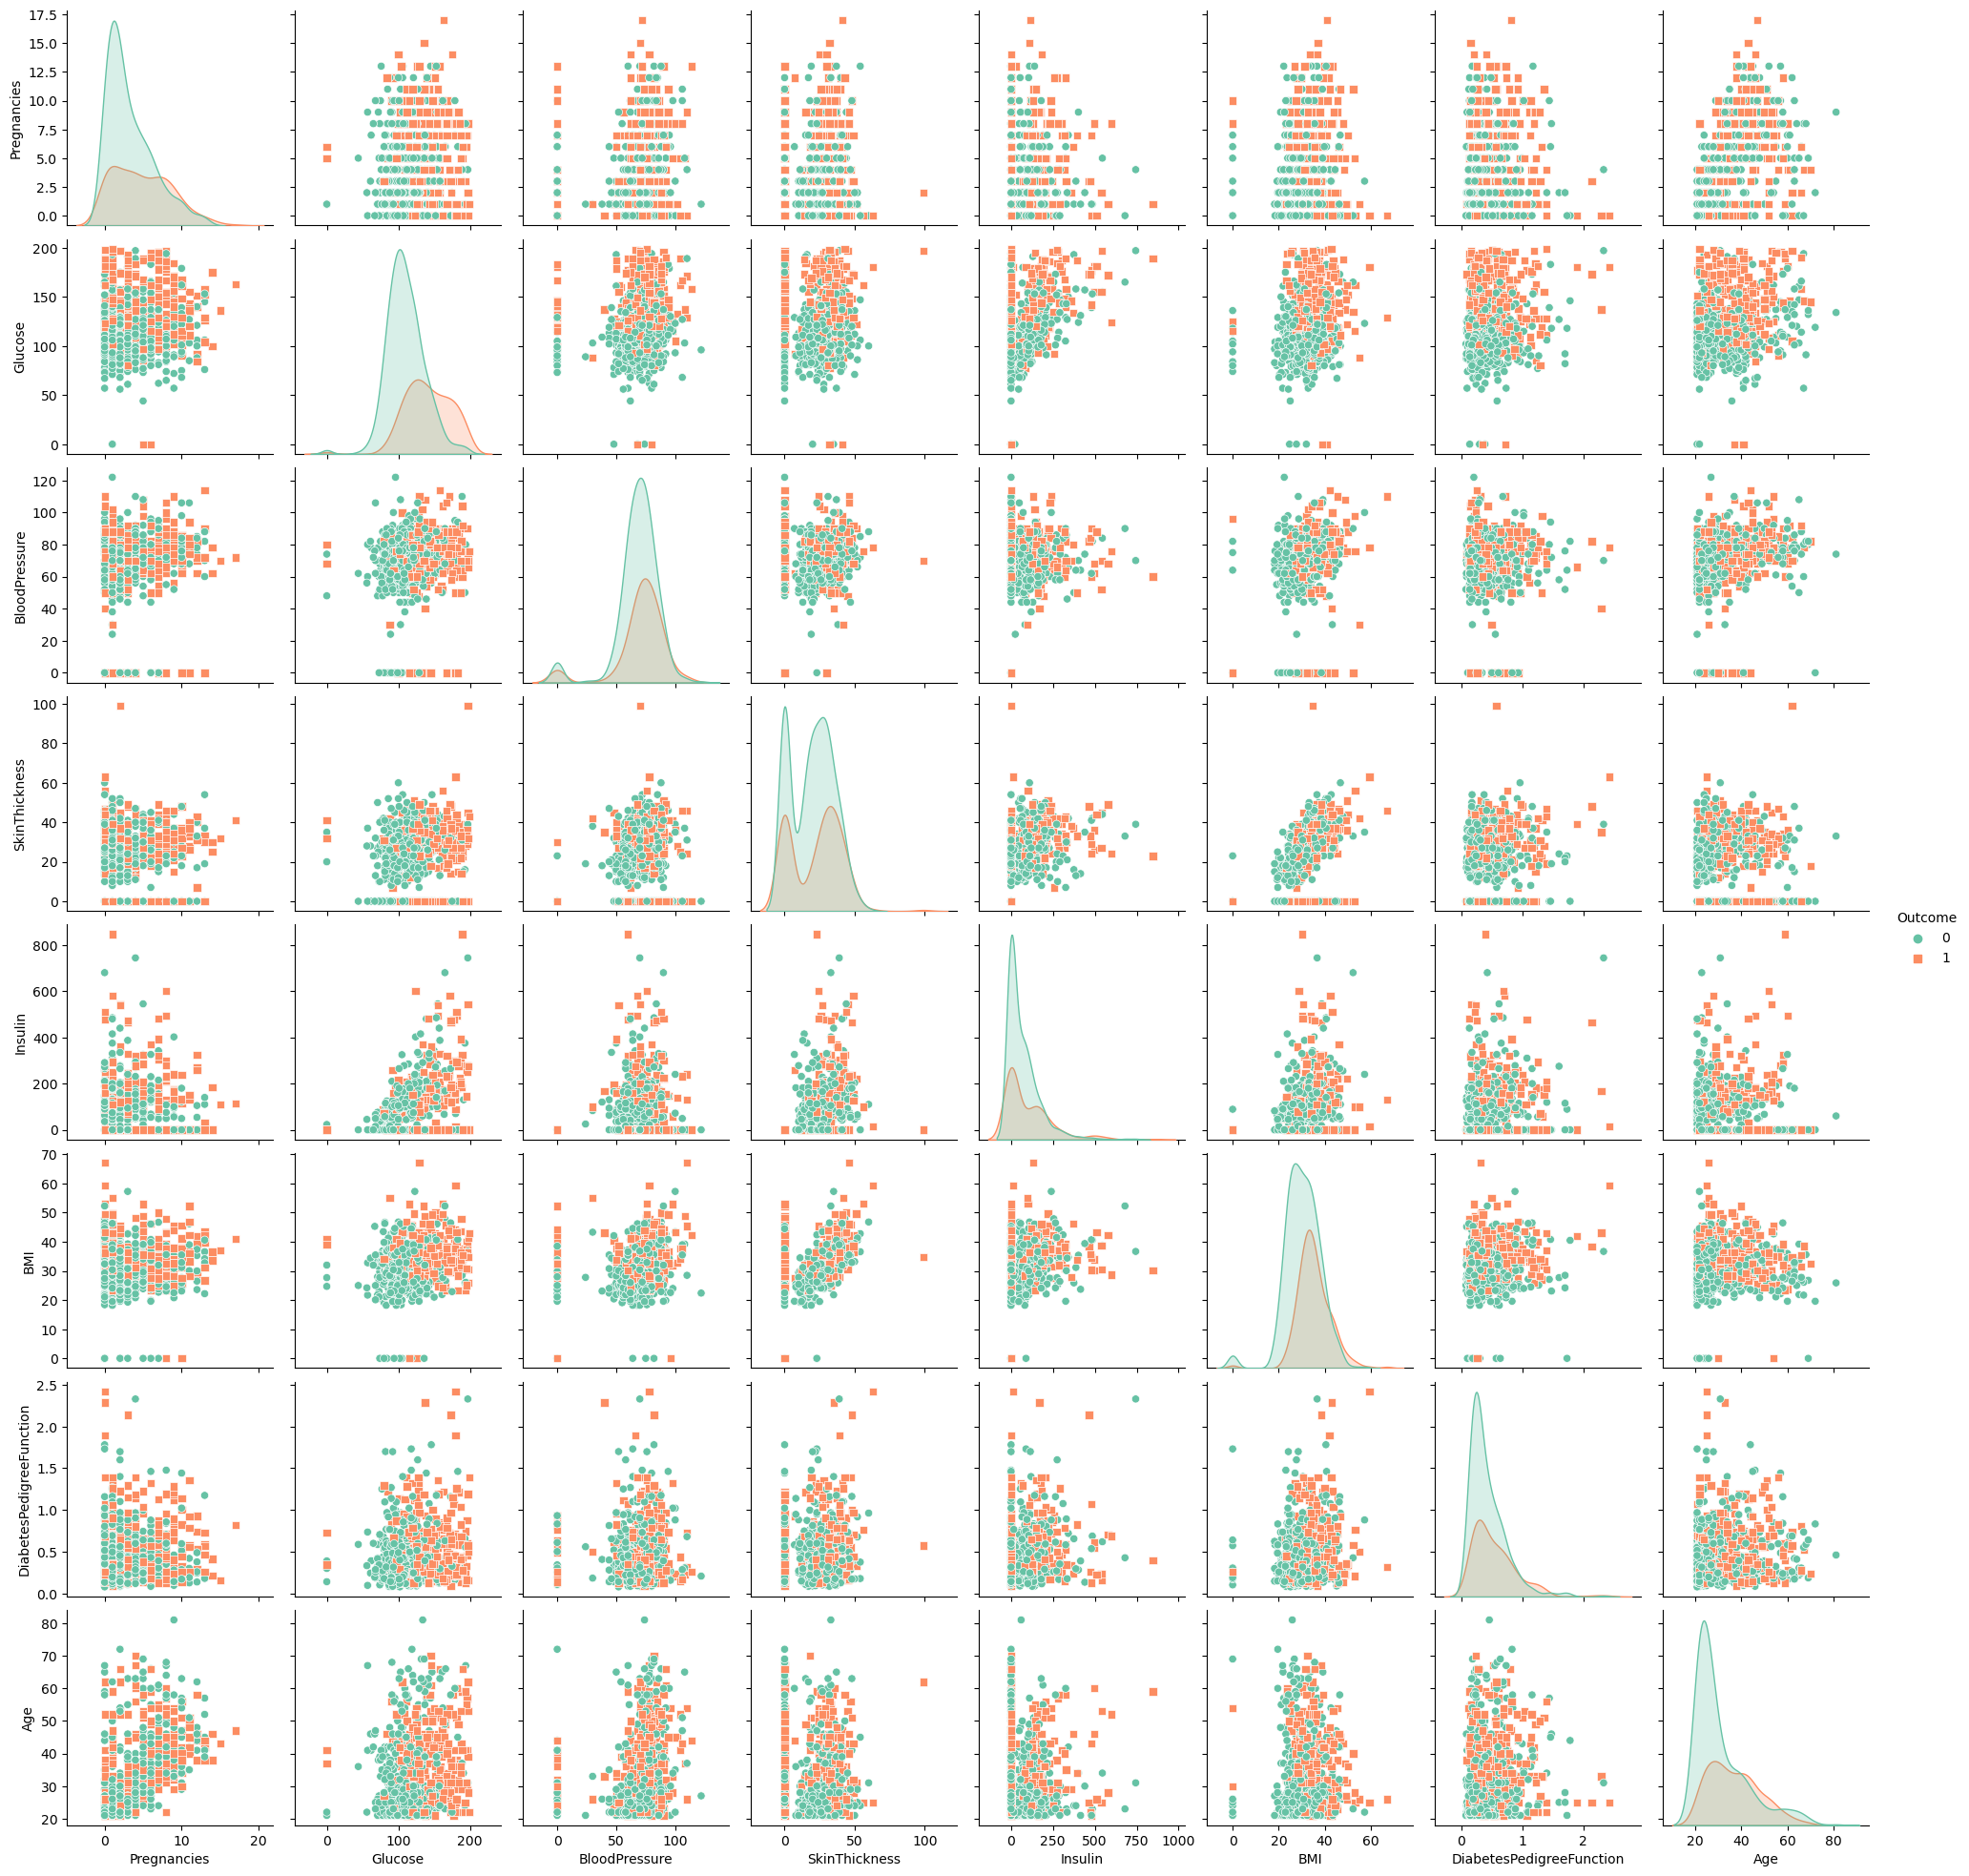

In [21]:
sns.pairplot(data,hue='Outcome',markers=["o","s"],palette="Set2")
plt.show()

In [22]:
scaler=StandardScaler()

In [23]:
data_scaled=scaler.fit_transform(data.drop('Outcome',axis=1))

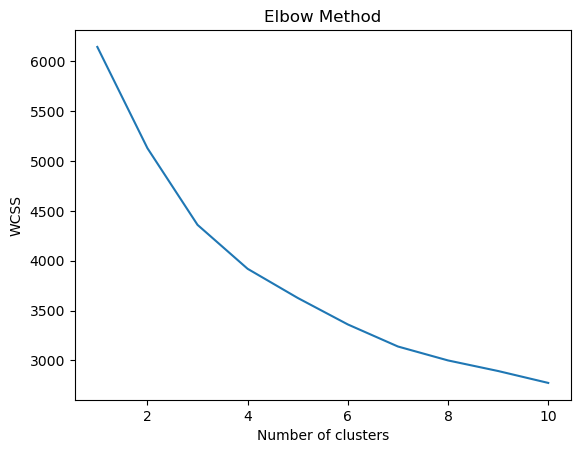

In [24]:
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

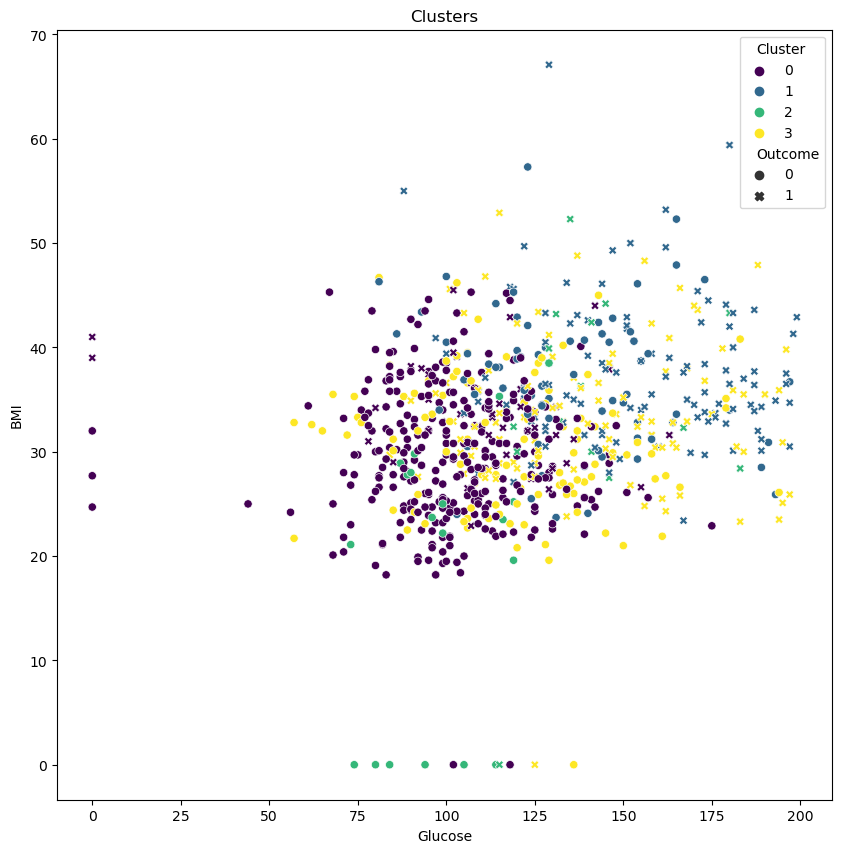

In [25]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(data_scaled)

data['Cluster'] = clusters

plt.figure(figsize=(10, 10))
sns.scatterplot(data=data, x='Glucose', y='BMI', hue='Cluster', style='Outcome', palette='viridis')
plt.title('Clusters')
plt.show()

In [26]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
model = CatBoostClassifier(verbose=0)
model.fit(X_train, y_train)

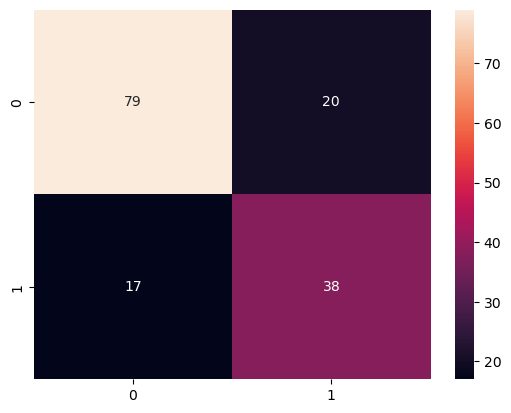

              precision    recall  f1-score   support

           0       0.82      0.80      0.81        99
           1       0.66      0.69      0.67        55

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154



In [28]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True)
plt.show()

print(classification_report(y_test, y_pred))

In [29]:
cv_scores = cross_val_score(model, X, y, cv=10)
print("Cross-validation scores:", cv_scores)

Cross-validation scores: [0.74025974 0.79220779 0.76623377 0.67532468 0.72727273 0.80519481
 0.83116883 0.83116883 0.71052632 0.80263158]


In [30]:
average_cv_score = np.mean(cv_scores)
print("Average cross-validation score: ", average_cv_score)

Average cross-validation score:  0.768198906356801


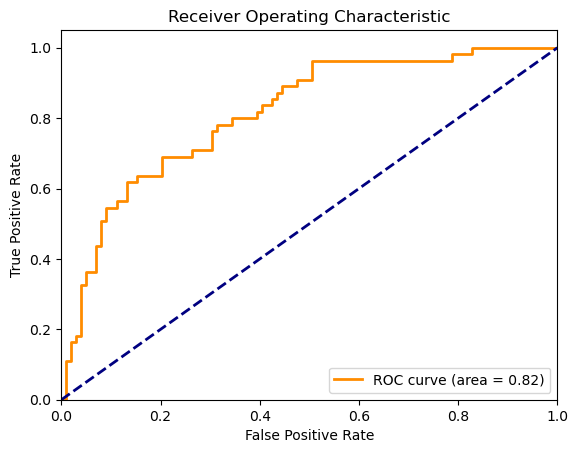

In [31]:
y_score = model.predict_proba(X_test)[:,1]

# ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

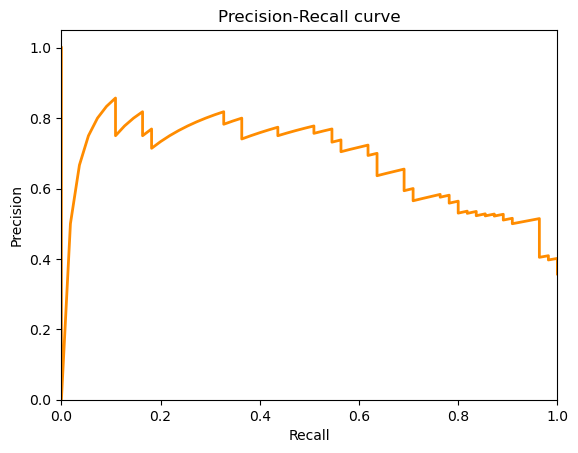

In [32]:
precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


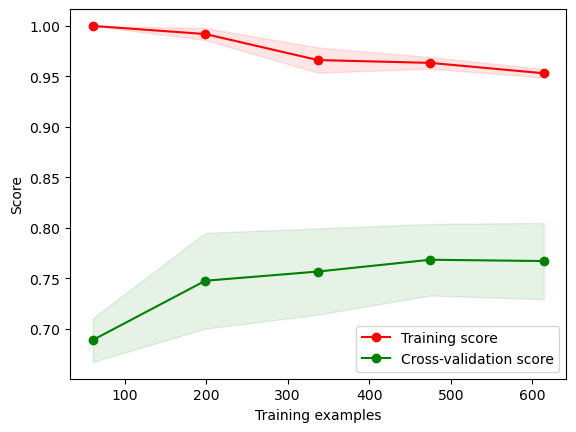

In [33]:
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, n_jobs=-1, 
                                                        train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [34]:
errors = y_test != y_pred
X_errors = X_test[errors]
y_errors = y_test[errors]
y_pred_errors = y_pred[errors]

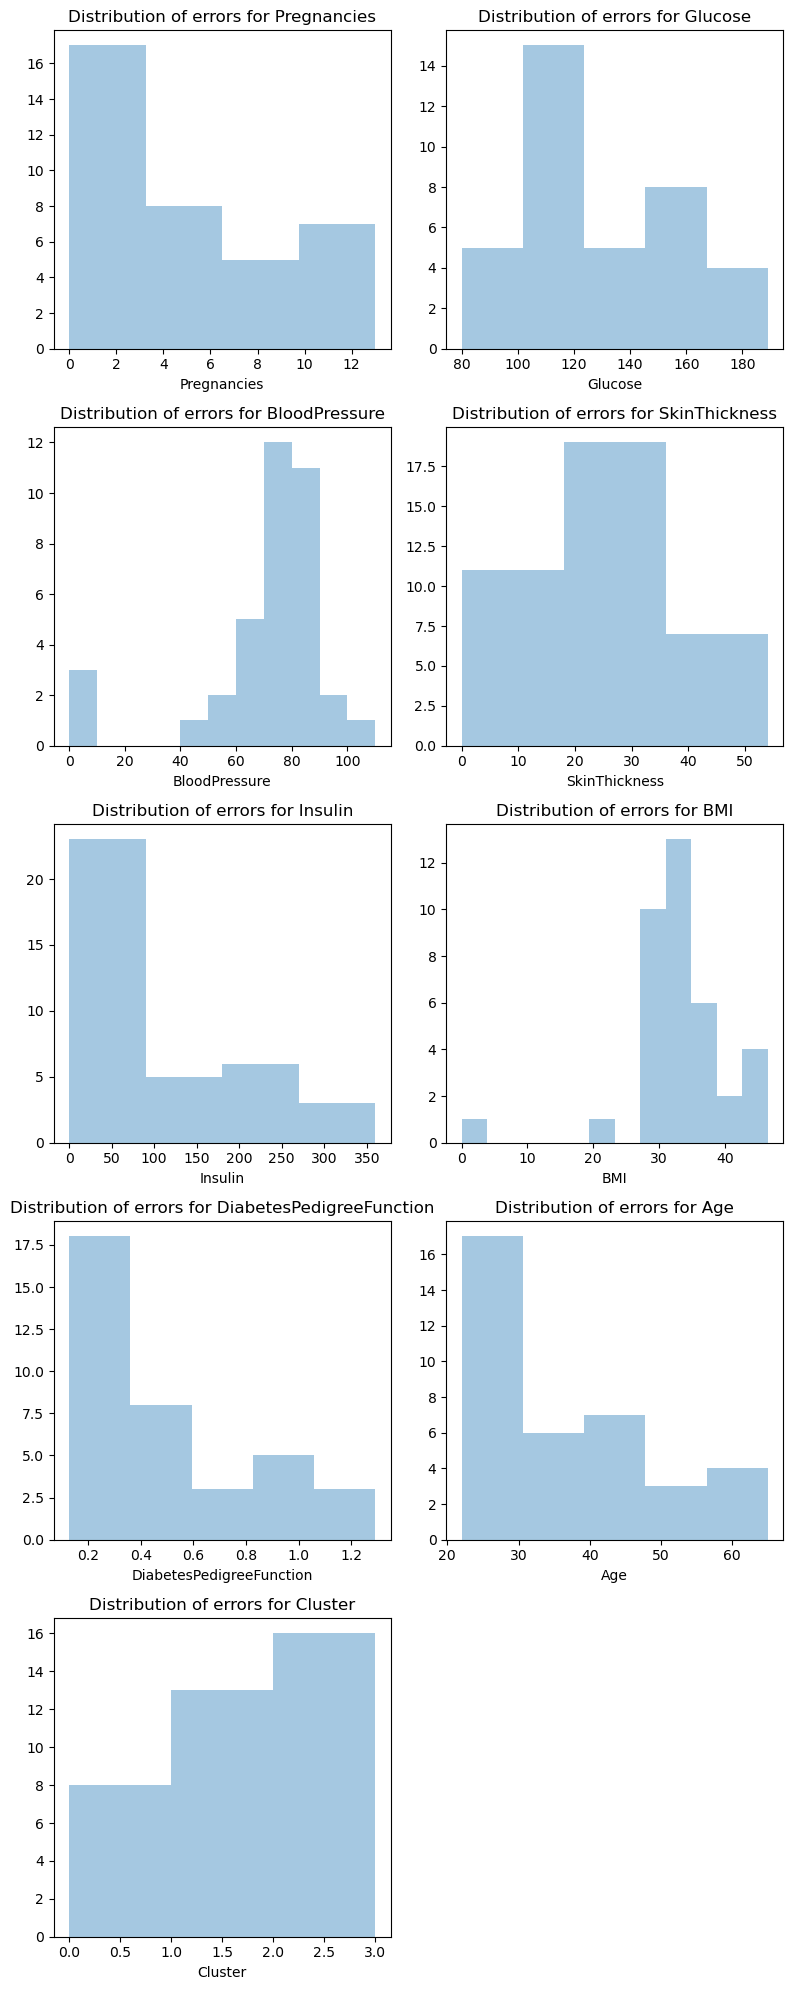

In [35]:
num_columns = len(X_errors.columns)
num_rows = (num_columns + 1) // 2

plt.figure(figsize=(8, 4*num_rows))
for i, column in enumerate(X_errors.columns):
    plt.subplot(num_rows, 2, i+1)
    sns.distplot(X_errors[column], kde=False)
    plt.title('Distribution of errors for {}'.format(column))

plt.tight_layout()
plt.show()

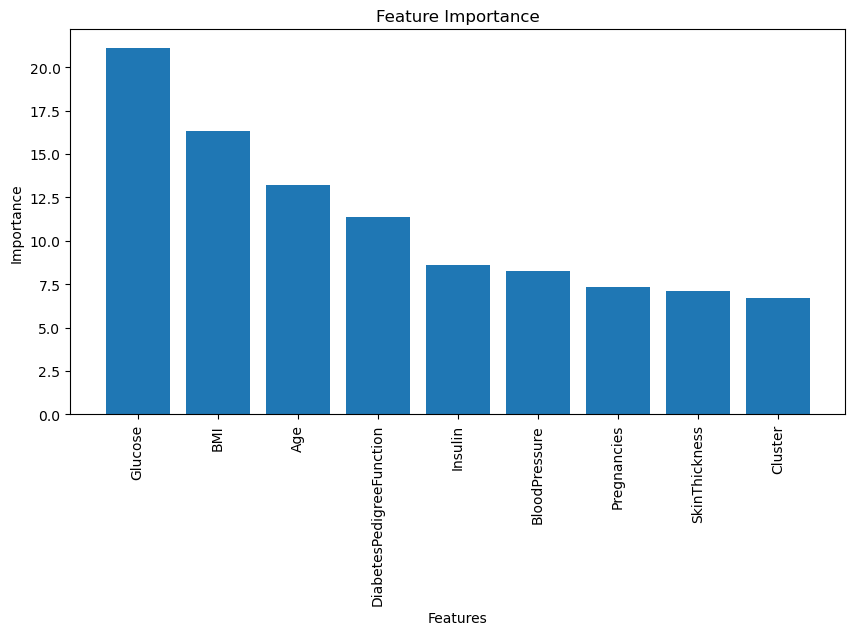

In [36]:
feature_importances = model.get_feature_importance(Pool(X, label=y))
feature_names = X.columns
importances = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

# Plotting feature importances
plt.figure(figsize=(10, 5))
plt.bar(*zip(*importances))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()

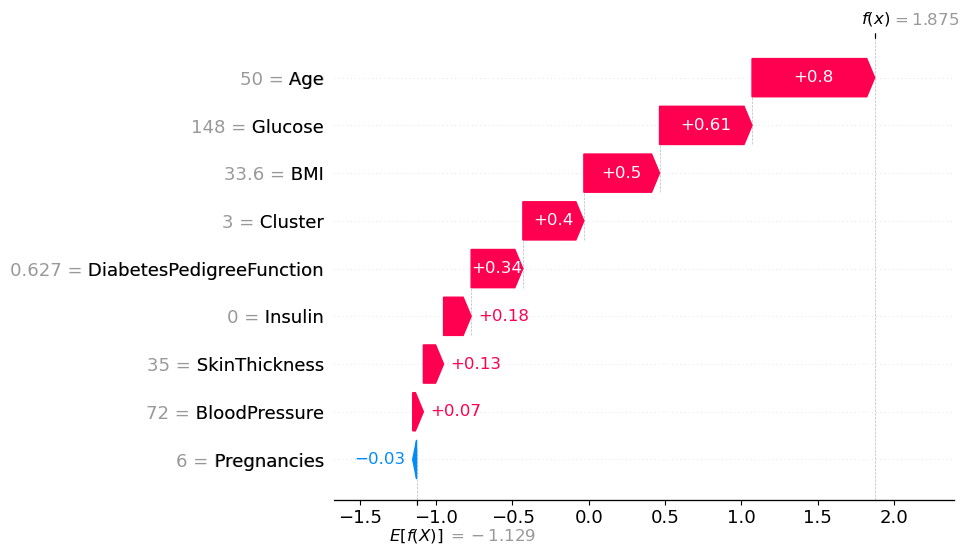

In [37]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.plots.waterfall(shap_values[0])

In [38]:
param_grid = {'iterations': [100, 150, 200],
              'depth': [2, 4, 6, 8],
              'learning_rate': [0.01, 0.05, 0.1]}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid.fit(X_train, y_train)

print("Best parameters found: ",grid.best_params_)

Best parameters found:  {'depth': 8, 'iterations': 150, 'learning_rate': 0.05}


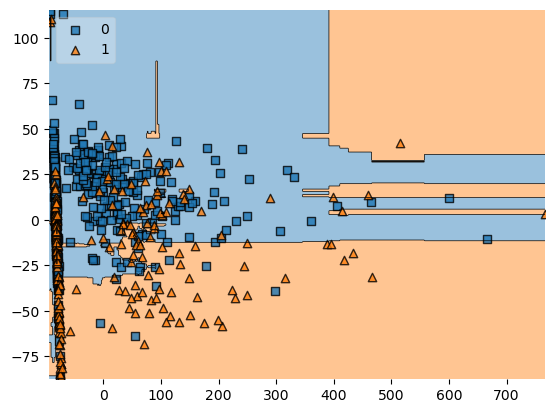

In [39]:
pca = PCA(n_components = 2)
X_train2 = pca.fit_transform(X_train)

model.fit(X_train2, y_train)
plot_decision_regions(X_train2, y_train.to_numpy(), clf=model, legend=2)
plt.show()